In [1]:
import tensorflow as tf
import h5py
import numpy as np
import scipy.misc
import random
import matplotlib.pyplot as plt
import os

## File Names

In [2]:
label_file = h5py.File('face_offset_labels_10k.h5','r+')
dataset_file = h5py.File('face_offset_data_10k.h5','r+')

## Dataset name within the hdf5 file

In [3]:
dataset_labels = label_file['/Labels/Labels']
dataset_images = dataset_file['/Data/Images']

## Check labels and data within the file

In [4]:
# Split to test and train data
Y_train = dataset_labels[0:10000,...]
Y_test = dataset_labels[10001:]

Y_train = Y_train*10

print(type(Y_train))
print(Y_train)

# Print label shapes
print("Train Label Shape:", Y_train.shape)
print("Test Label Shape:", Y_test.shape)

<class 'numpy.ndarray'>
[[ 0.          0.        ]
 [-0.92000002 -0.54000002]
 [-0.22       -0.29999998]
 ..., 
 [ 0.38       -0.41999999]
 [-0.61000001 -0.14      ]
 [-0.75       -0.46000001]]
Train Label Shape: (10000, 2)
Test Label Shape: (325, 2)


In [6]:
# Split to test and train data
X_train = dataset_images[0:10000,...]
X_test = dataset_images[10001:]

print(type(X_train))

# Print data shapes
print("Train Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)
print(X_train[0])

<class 'numpy.ndarray'>
Train Data Shape: (10000, 120, 120, 3)
Test Data Shape: (325, 120, 120, 3)
[[[ 0.71372551  0.71372551  0.71372551]
  [ 0.73725492  0.73725492  0.73725492]
  [ 0.73333335  0.73333335  0.73333335]
  ..., 
  [ 0.71372551  0.71372551  0.71372551]
  [ 0.72549021  0.72549021  0.72549021]
  [ 0.72549021  0.72549021  0.72549021]]

 [[ 0.70588237  0.70588237  0.70588237]
  [ 0.72156864  0.72156864  0.72156864]
  [ 0.70980394  0.70980394  0.70980394]
  ..., 
  [ 0.71372551  0.71372551  0.71372551]
  [ 0.73333335  0.73333335  0.73333335]
  [ 0.74117649  0.74117649  0.74117649]]

 [[ 0.76862746  0.76862746  0.76862746]
  [ 0.7764706   0.7764706   0.7764706 ]
  [ 0.76862746  0.76862746  0.76862746]
  ..., 
  [ 0.72941178  0.72941178  0.72941178]
  [ 0.67450982  0.67450982  0.67450982]
  [ 0.65490198  0.65490198  0.65490198]]

 ..., 
 [[ 0.15294118  0.15294118  0.15294118]
  [ 0.14901961  0.14901961  0.14901961]
  [ 0.15294118  0.15294118  0.15294118]
  ..., 
  [ 0.15686275  

## View an image and label from the file

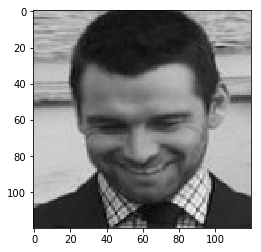

X offset is: 0.000000 , Y offset is: 0.000000


In [7]:
img_no = 0

# Grab selected image and label
img = X_train[img_no,:,:,:]
offset = Y_train[img_no,:]

# Make data value betwee 0 and 255
img = img*255

# Show the images
plt.imshow(np.uint8(img))
plt.show()
print("X offset is: %f" % (offset[0]), ", Y offset is: %f" % (offset[1]))

## Histogram of label distribution

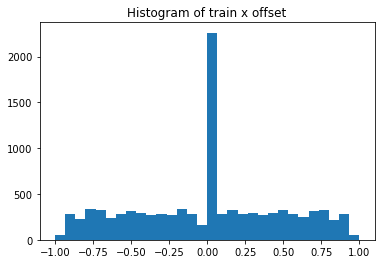

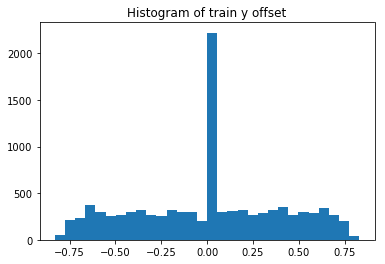

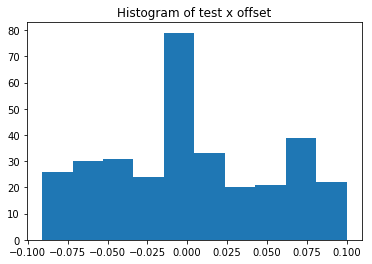

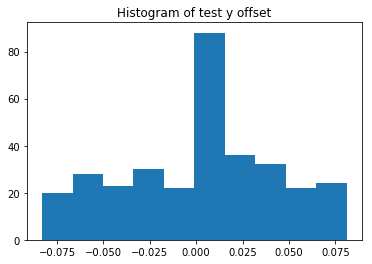

In [8]:
plt.hist(Y_train[:,0], bins='auto')
plt.title("Histogram of train x offset")
plt.show()
plt.hist(Y_train[:,1], bins='auto')
plt.title("Histogram of train y offset")
plt.show()
plt.hist(Y_test[:,0], bins='auto')
plt.title("Histogram of test x offset")
plt.show()
plt.hist(Y_test[:,1], bins='auto')
plt.title("Histogram of test y offset")
plt.show()

# Tensorflow Training

##### Start our 'session' (these are the connection between the c++ backend and python. Common usage in TF is to create your graph then launch it in a session

In [9]:
import model_util as util
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [10]:
# Placeholders for our input variables, None indicates batch size is variable
x = tf.placeholder(tf.float32, shape=[None, 120, 120, 3 ])
y_ = tf.placeholder(tf.float32, shape=[None, 2])

dropout_prob = tf.placeholder(tf.float32)
x_image = x

##### Define our model (uses model_util.py to help define conv2d etc.)

In [11]:
# Conv1 
conv1 = util.conv2d(x_image, 5, 5, 3, 24, 2,"conv1",True)

# CONV 2
conv2 = util.conv2d(conv1, 5, 5, 24, 36, 2,"conv2")

# CONV 3
conv3 = util.conv2d(conv2, 5, 5, 36, 48, 2,"conv3")

# CONV 4
conv4 = util.conv2d(conv3, 3, 3, 48, 64, 1, "conv4")

# CONV 5
conv5 = util.conv2d(conv4, 3, 3, 64, 64, 1, "conv5")

# Fully Connect 1
# Needs calculation... (-1 means any batch size)
conv5_flat = tf.reshape(conv5, [-1, 14400])

fc1 = util.fc_layer(conv5_flat, 14400, 1164, "fc1")
# Add dropout to the fully connected layer
fc1_drop = tf.nn.dropout(fc1,dropout_prob )

# Fully Connect 2
fc2 = util.fc_layer(fc1_drop, 1164, 100, "fc2")
# Add dropout to the fully connected layer
fc2_drop = tf.nn.dropout(fc2, dropout_prob)

# Fully Connect 3
fc3 = util.fc_layer(fc2_drop, 100, 50, "fc3")
# Add dropout to the fully connected layer
fc3_drop = tf.nn.dropout(fc3, dropout_prob)

# Fully Connect 4
fc4 = util.fc_layer(fc3_drop, 50, 10, "fc4")
# Add dropout to the fully connected layer
fc4_drop = tf.nn.dropout(fc4, dropout_prob)

#Output
out_layer = util.output_layer(fc4_drop, 10, 2, "output_layer")

y = out_layer

### HyperParams, losses and solver set up

In [12]:
L2NormConst = 0.001
start_lr = 0.0001
epochs = 300
batch_size = 200

train_vars = tf.trainable_variables()

with tf.name_scope("MSE_Loss_L2Reg"):
        loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n(
[tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
        
with tf.name_scope("Loss_Validation"):
    loss_val = tf.reduce_mean(tf.square(tf.subtract(y_,y)))

with tf.name_scope("Solver"):
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = start_lr
    
    # decay every 10000 steps with a base of 0.96
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               10000, 0.96, staircase=True)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

sess.run(tf.global_variables_initializer())

# Set max_to_keep to 0 to save all checkpoints
saver = tf.train.Saver(max_to_keep=0)

tf.summary.scalar("loss_train", loss)
tf.summary.scalar("loss_val", loss_val)
tf.summary.scalar("learning_rate", learning_rate)
tf.summary.scalar("global_step", global_step)
merged_summary_op = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("C:/Users/ricbur01/Work/Tensorflow/MNist_1.0/check")
summary_writer.add_graph(sess.graph)

In [13]:
save_dir = '.\check'
os.path.exists(save_dir)

True

### Training Loop 

In [ ]:
for epoch in range(epochs):
    
    
    for i in range(int(10000/ batch_size)):
        xs = X_train[i:i+batch_size,:,:,:]
        ys = Y_train[i:i+batch_size,:]
    
        train_step.run(feed_dict={x: xs, y_: ys, dropout_prob: 0.8})
        
        summary = merged_summary_op.eval(feed_dict={x: xs, y_: ys, dropout_prob: 1.0})
        summary_writer.add_summary(summary, epoch * batch_size + i)
    
    
    
    loss_value = loss_val.eval(feed_dict={x: xs, y_: ys, dropout_prob: 1.0})
    print(epoch, ":", loss_value)
    checkpoint_path = os.path.join(save_dir, "model-ckpt")
    filename = saver.save(sess, checkpoint_path, epoch)
    

In [15]:
# Restore our model

#sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "C:/Users/ricbur01/Work/Tensorflow/MNist_1.0/offset_regression_10k_models/model-ckpt-294")


INFO:tensorflow:Restoring parameters from C:/Users/ricbur01/Work/Tensorflow/MNist_1.0/offset_regression_10k_models/model-ckpt-294


### Test an image

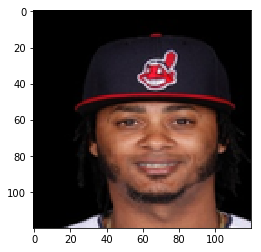

0.192157
(1, 120, 120, 3)


In [30]:
img_no = 0
test_im = X_test[img_no,:,:,:]

plt.imshow(np.uint8(test_im*255))
plt.show()

print(test_im[55,55,2])
test_im = test_im[np.newaxis,...]
print(test_im.shape)


In [31]:
print("predicted x,y offset:",(y.eval(feed_dict={x: test_im, dropout_prob:1}))/10)
offset = Y_test[img_no,:]
print("label offset:", offset)

predicted x,y offset: [[-0.03291516  0.01916824]]
label offset: [-0.054 -0.02 ]
